Memuat gambar...


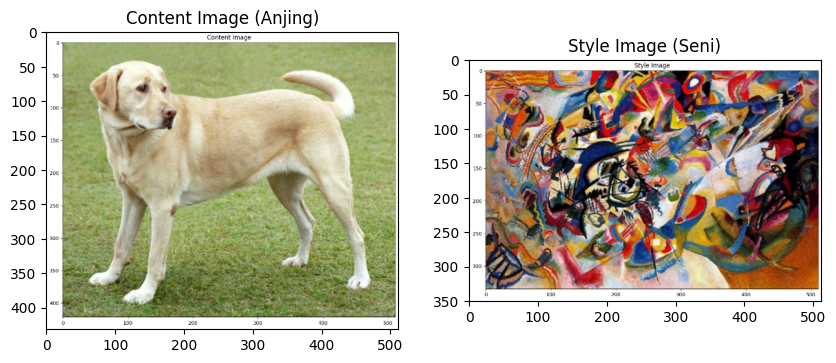

Mulai proses Style Transfer...
....................................................................................................
Epoch: 1/1 selesai.


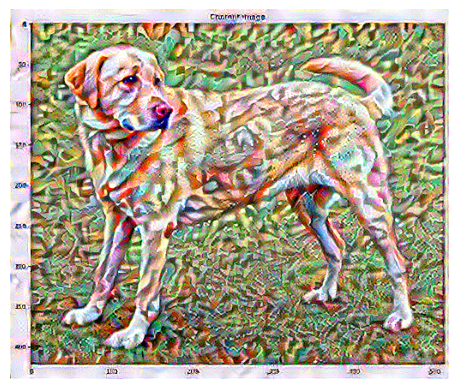

Total waktu: 905.9 detik
Gambar berhasil disimpan sebagai 'hasil_style_transfer_anjing.jpg'


In [ ]:
import tensorflow as tf
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import time
from tensorflow.keras.applications import vgg19

# ==========================================
# KONFIGURASI DAN PERSIAPAN
# ==========================================

# Ubah path ini sesuai dengan nama file yang Anda upload di Colab
content_path = '/content/gambar 1.png'  # Gambar Anjing (Content)
style_path = '/content/gambar 2.png'    # Gambar Abstrak (Style)

def tensor_to_image(tensor):
  """Mengubah tensor TensorFlow kembali menjadi gambar biasa untuk ditampilkan."""
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  """Memuat gambar dan mengubah ukurannya agar tidak terlalu besar untuk diproses."""
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  if title:
    plt.title(title)

# ==========================================
# 1. MEMUAT GAMBAR
# ==========================================
print("Memuat gambar...")
try:
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    imshow(content_image, 'Content Image (Anjing)')
    plt.subplot(1, 2, 2)
    imshow(style_image, 'Style Image (Seni)')
    plt.show()
except Exception as e:
    print(f"Error: Pastikan file '{content_path}' dan '{style_path}' sudah diupload ke Colab.")
    print(f"Detail Error: {e}")

# ==========================================
# 2. MEMBANGUN MODEL (VGG19)
# ==========================================

# Kita menggunakan VGG19 yang sudah dilatih pada ImageNet
# Kita tidak membutuhkan classifier (top layers), hanya ekstraksi fitur
def vgg_layers(layer_names):
  """ Membuat model VGG19 yang mengembalikan output dari layer layer tertentu """
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

# Memilih layer untuk Content dan Style
# Content layer biasanya lebih dalam untuk menangkap bentuk objek (anjing)
content_layers = ['block5_conv2']

# Style layer diambil dari berbagai kedalaman untuk menangkap tekstur kasar hingga halus
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def gram_matrix(input_tensor):
  """ Menghitung Gram Matrix untuk representasi gaya (korelasi antar filter) """
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # Preprocessing input agar sesuai dengan ekspektasi VGG19 (0-255)
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

# Inisialisasi Model
extractor = StyleContentModel(style_layers, content_layers)

# ==========================================
# 3. TRAINING LOOP (GRADIENT DESCENT)
# ==========================================

# Target gaya dan konten
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Gambar awal adalah salinan dari gambar konten (Anjing)
image = tf.Variable(content_image)

def clip_0_1(image):
  """ Memastikan nilai pixel tetap di antara 0.0 dan 1.0 """
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

# Bobot untuk menyeimbangkan seberapa banyak gaya vs konten
style_weight = 1e-2  # Tingkatkan jika ingin lebih artistik
content_weight = 1e4 # Tingkatkan jika ingin bentuk anjing lebih jelas

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    # Total variation loss untuk mengurangi noise frekuensi tinggi
    loss += tf.image.total_variation(image) * 30

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

# ==========================================
# 4. EKSEKUSI TRAINING
# ==========================================

print("Mulai proses Style Transfer...")
start = time.time()

epochs = 1
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(f".", end='', flush=True)

  # Tampilkan hasil setiap epoch
  print(f"\nEpoch: {n+1}/{epochs} selesai.")
  plt.imshow(tensor_to_image(image))
  plt.axis('off')
  plt.show()

end = time.time()
print(f"Total waktu: {end-start:.1f} detik")

# Simpan hasil akhir
final_img = tensor_to_image(image)
final_img.save('hasil_style_transfer_anjing.jpg')
print("Gambar berhasil disimpan sebagai 'hasil_style_transfer_anjing.jpg'")